In [1]:
from itertools import product
from typing import Dict, List, Any

import numpy as np
import matplotlib.pyplot as plt

from IOData.IOData import InputRule

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType, ControllerTypes
from tools.simualtion_results import Results
from tools.simple_track_generator import trackGenerator

In [2]:
save_fig = False

simualte_type = 'TRACK_SIMULATE'

Simulator = {
    # 'SINGLE_CURVATURE'  : SingleCurvatureSimulator,
    'TRACK_SIMULATE'    : TrackSimulator,
}.get(simualte_type)

simulator = Simulator()
simulator.a_d_max = 2
simulator.delta_d_max = 0.12
simulator.use_saved_data = False
simulator.save_data = True
simulator.simulate_model_type = ModelType.DYNAMIC_WITH_L
simulator.data_model_type = ModelType.DYNAMIC_WITH_L
simulator.filter_model_type = ModelType.DYNAMIC_WITH_L
simulator.t_sim = 13.0
simulator.num_predicted_traj = 10
simulator.global_initial_state = np.array([0.0, 0.0, 0.0, 0.5, 0.0, 0.0])
simulator.cur = 1/1.0
simulator.track_fun_name = 'oval_track'
simulator.lag = 10
simulator.save_predicted_traj = True
simulator.save_dataset_after = True
simulator.delete_dataset_after = True
# simulator.v_x_max = 2.7
simulator.v_y_max = 2.0

simulator.t_data = 10.0
t_new_data = simulator.t_data * 0.6
simulator.data_input_rule = InputRule.PRBS_TIMES_RANDOM_MEAN

# simulator.n_v_max = 0
simulator.n_x, simulator.n_y, simulator.n_psi, simulator.n_v = 0,0,0,0
simulator.n_e_lat_max, simulator.n_mu_max, simulator.n_v_max, simulator.n_l_max = 0,0,0,0 # for test of prediction error

random_seed = 0
track_filter_type = TrackFilterTypes.SINGLE_SEGMENT
filter_type = SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L
application_filter_type = ControllerTypes.INDIRECT_FIX_MU_MAX_L
    
filter_param: List[Dict[str, Any]] = {
    SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING: [
        {'lam_sig': 50000, 'L': 80, 'R': np.matrix('1,0;0,1'),
        'c': [[0.25, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': 0.1, 'min_num_slices': int(0.45*simulator.t_data/simulator.Ts), 'min_portion_slices': 0.4, 'f': lambda x: 1/(1.1*x)**2},
    ],
    SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L: [
        {'lam_sig': 50000, 'L': 80, 'R': np.matrix('1,0;0,1'),
        'c': [[0.25, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': 0.1, 'min_num_slices': int(0.45*simulator.t_data/simulator.Ts), 'min_portion_slices': 0.4, 'f': lambda x: 1/(1.1*x)**2},
    ],
    ControllerTypes.INDIRECT_FIX_MU_MAX_L: [
        {'lam_sig': 100, 'L': 80, 'R': np.matrix('1,0;0,1'),
        'c': [[0.3, 0.15, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.3, 0.15, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': 0.2,
        'min_num_slices': int(0.45*simulator.t_data/simulator.Ts),
        'min_portion_slices': 0.4,
        # 'f': lambda x: 1/(1.1*x)**2,
        # 'f': lambda x: 1,
        # 'f': lambda x: np.exp(-x**2),
        'f': lambda x: np.exp(-x**2) + 8,
        'use_zero_l_initial': True,
        'verbose': False,
        'solver': None,
        'solver_args': {}
        },
    ],
    SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA: [
        {'lam_sig': 50000, 'L': 80, 'R': np.matrix('1,0;0,1'),
        'c': [[0.25, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.2, 0.1, 0.05, 0.01], [0.1, 0.05, 0.01, 0.005]], 't_new_data': t_new_data,
        'min_dist': 0.1, 'min_num_slices': int(0.45*simulator.t_data/simulator.Ts), 'min_portion_slices': 0.4, 'f': lambda x: 1/(1.1*x)**2},
    ],
    }
simulation_input_rules = [
    SimulationInputRule.SINE_WITH_MEAN,
    # SimulationInputRule.MAX_THROTTLE,
    # SimulationInputRule.MAX_THROTTLE_SINE_STEER,
    ]
collection_rule = SimulationInputRule.RANDOM_WITH_MEAN

list_results_list = []
for collection_params, application_params in product(filter_param[filter_type], filter_param[application_filter_type]):
    results_list = simulator.simulate_with_separate_collection(random_seed, track_filter_type, filter_type, application_filter_type, collection_params, application_params, collection_rule, simulation_input_rules, 10, continue_to_end=True)
    list_results_list.append(results_list)


Running with initial dataset

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [1000]
Constraint not satisfied at time 1.07.
vehicle moved to segment 1!
Constraint satisfied again at time 1.98.
vehicle moved to segment 2!


At t = 0.00105639, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results
vehicle moved to segment 3!
Constraint not satisfied at time 5.86.
Constraint satisfied again at time 6.3500000000000005.
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
Constraint not satisfied at time 11.13.
Constraint satisfied again at time 11.43.
vehicle moved to segment 2!


Simulating with input rule SimulationInputRule.RANDOM_WITH_MEAN
And with first dataset list [1000]
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!

Continue to simulate

Simulating with input rule Simulati

/opt/anaconda3/envs/DDSF_new/lib/python3.9/site-packages/numpy/linalg/linalg.py:2027: RuntimeWarning: overflow encountered in divide
  s = divide(1, s, where=large, out=s)
/opt/anaconda3/envs/DDSF_new/lib/python3.9/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning: invalid value encountered in matmul
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))


Exception Workspace allocation error! raised during optimization, returning partial resultsERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.



And with first dataset list [1000, 188, 128]
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 1!
Constraint not satisfied at time 9.81.
Stop simulation after constraint not satisfied!

Continue to simulate

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [1000, 188, 128, 148, 116]
Constraint not satisfied at time 0.62.
Exception Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information. raised during optimization, returning partial results


And with first dataset list [1000, 188, 128, 148, 116]
v

/opt/anaconda3/envs/DDSF_new/lib/python3.9/site-packages/numpy/linalg/linalg.py:2030: RuntimeWarning: invalid value encountered in multiply
  res = matmul(transpose(vt), multiply(s[..., newaxis], transpose(u)))


ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
Exception Workspace allocation error! raised during optimization, returning partial results


ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
And with first dataset list [1000, 188, 128, 148, 116, 148]
vehicle moved to segment 1!
Constraint not satisfied at time 2.0100000000000002.
Stop simulation after constraint not satisfied!

Continue to simulate

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [1000, 188, 128, 148, 116, 148, 152]
Constraint not satisfied at time 0.37.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
Exception Workspace allocation error! raised during optimization, returning partial results


ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
And wi

At t = 0.00530759, mxstep steps taken before reaching tout.


Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. during simulation of real system, returning partial results


At t = 0.00532047, mxstep steps taken before reaching tout.


Exception Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. raised during system simulation, returning partial results


And with first dataset list [1000, 188, 128, 148, 116, 148, 152, 156, 152]
vehicle moved to segment 1!
Constraint not satisfied at time 2.08.
Stop simulation after constraint not satisfied!

Continue to simulate

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [1000, 188, 128, 148, 116, 148, 152, 156, 152, 148]
Constraint not satisfied at time 0.58.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
Exception Workspace allo

At t = 0.00888923, mxstep steps taken before reaching tout.


Exception Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation. raised during system simulation, returning partial results


And with first dataset list [1000, 188, 128, 148, 116, 148, 152, 156, 152, 148, 148]
vehicle moved to segment 1!
Constraint not satisfied at time 1.95.
Stop simulation after constraint not satisfied!

Continue to simulate

Simulating with input rule SimulationInputRule.SINE_WITH_MEAN
And with first dataset list [1000, 188, 128, 148, 116, 148, 152, 156, 152, 148, 148, 144]
Constraint not satisfied at time 1.04.
vehicle moved to segment 1!
vehicle traveld to previous segment 0!
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
Exception Workspace 

/Users/huangyujun/Library/CloudStorage/OneDrive-ETHZurich/PersonalDocuments/2023SpringETH/DataDrivenSF/simulation/Controllers/IndirectFixMuMaxL.py:400: RuntimeWarning: invalid value encountered in matmul
  Phi = H_future_noised @ D_inv_Huy_T @ npl.pinv(H_uy_noised @ D_inv_Huy_T)


20


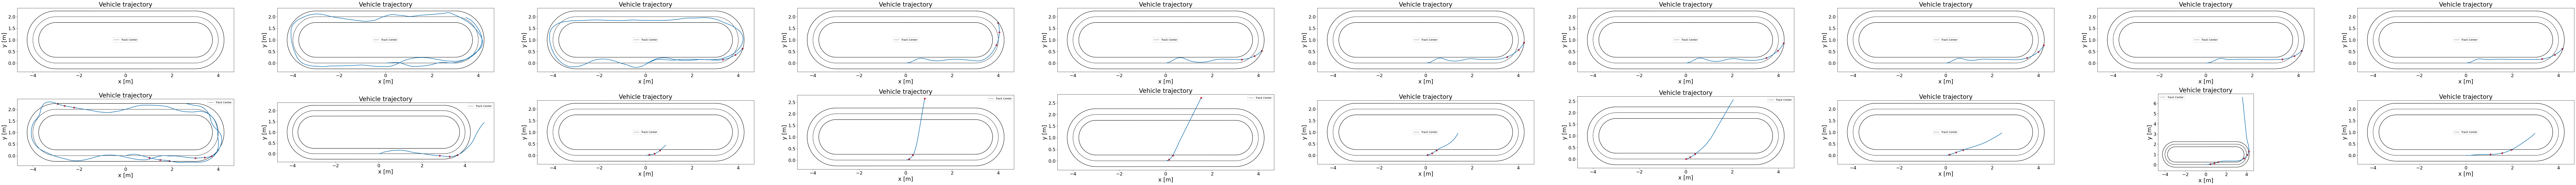

In [3]:
results_list: List[Results] = list_results_list[0]
print(len(results_list))
# plot global trajectory and track
n_cols, n_rows = int((len(results_list))/(len(simulation_input_rules)+1)), len(simulation_input_rules)+1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False, figsize=(18*n_cols,6*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        results = results_list[i+j*n_rows]
        if results is not None:
            results.plot_vehicle_trajectory(ax=axs[i,j], gen=simulator.track_generator, plot_marked_steps=True)
plt.show()
if save_fig:
    fig.savefig('fig/track_simulation.pdf', bbox_inches='tight')

In [4]:
print(len(results_list))
for results in results_list[1::2]:
    # print(results.average_intervention)
    # results.calculate_lap_time()
    print(results.violating_time)

print('lap time')
for results in results_list[1::2]:
    results.calculate_lap_time()
    print(results.lap_time)

20
1.6999999999999993
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.01
0.0
lap time
9.120000000000001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
results = results_list[1]
results.calculate_violation_time()

1.6999999999999993

In [6]:
import datetime
import os
import pickle
time = f"{datetime.datetime.now():%m-%d_%H_%M}"
file_name = time + "-" + "results_list" + ".pkl"
with open(os.path.join(os.getcwd(), 'datasets', file_name), 'wb') as file:
    pickle.dump(results_list, file)

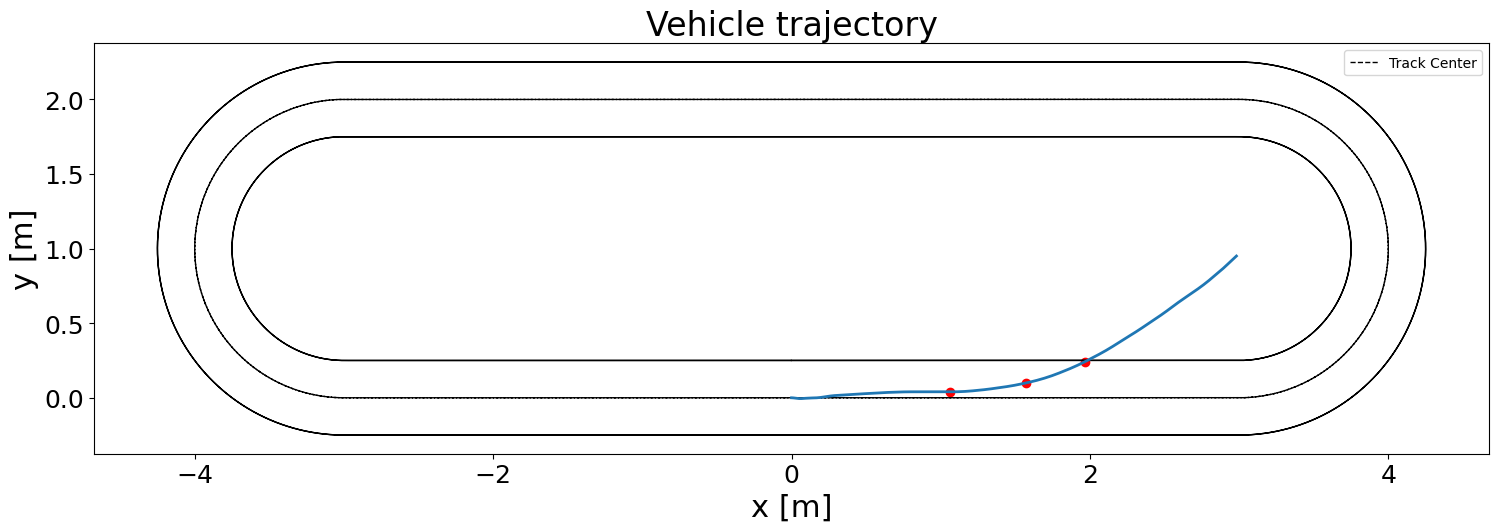

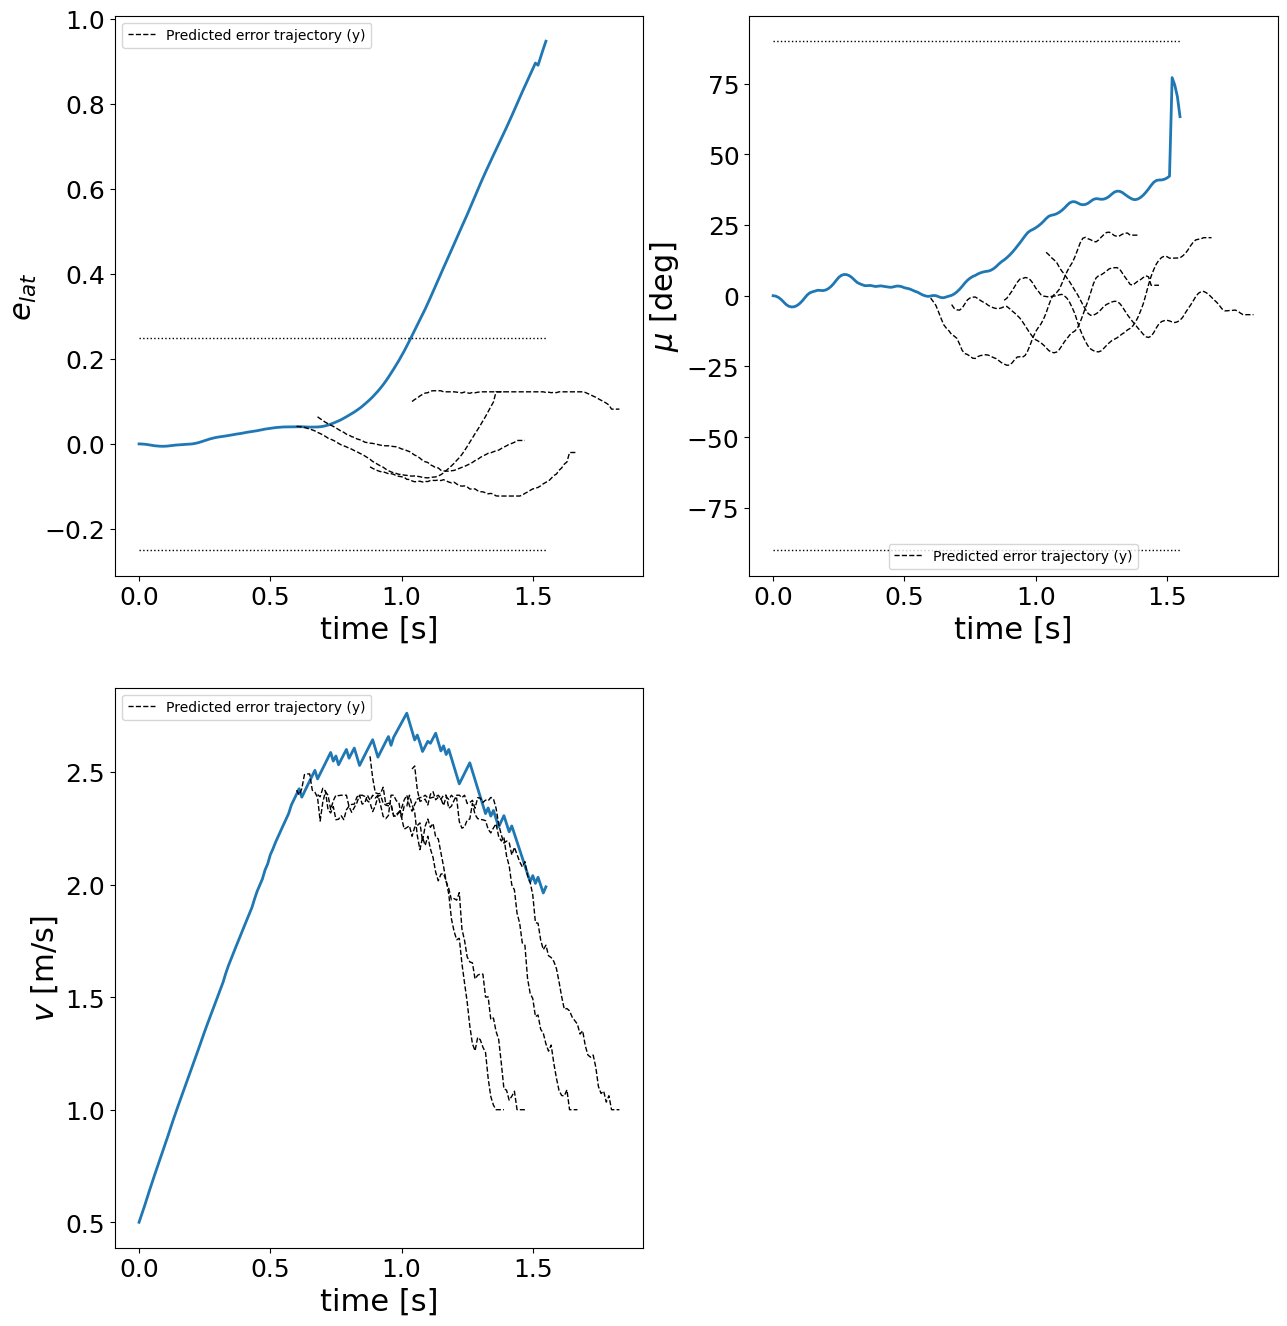

In [7]:
# choose one result to plot details
results = results_list[-1]
# results = dict_results[(random_seed, track_filter_types[0], SafetyFilterTypes.INDIRECT_ZERO_V, simulation_input_rules[0])][0]
fig, ax = plt.subplots(figsize=(18,6))
results.plot_vehicle_trajectory(ax=ax, gen=simulator.track_generator, plot_marked_steps=True)
plt.savefig('fig/track-simulation-single-trajectory.pdf', bbox_inches='tight')

# plot given error dynamics trajectory
plt.figure(figsize=(15,16))
#velocity input
ax = plt.subplot(221)
results.plot_error_trajectory(0, ax, constraint=(-simulator.track_width/2, simulator.track_width/2))
results.plot_predicted_error_slices(0, ax)
ax = plt.subplot(222)
results.plot_error_trajectory(1, ax, constraint=(simulator.mu_min*180/np.pi, simulator.mu_max*180/np.pi))
results.plot_predicted_error_slices(1, ax)
ax = plt.subplot(223)
results.plot_error_trajectory(2, ax)
results.plot_predicted_error_slices(2, ax)
plt.show()

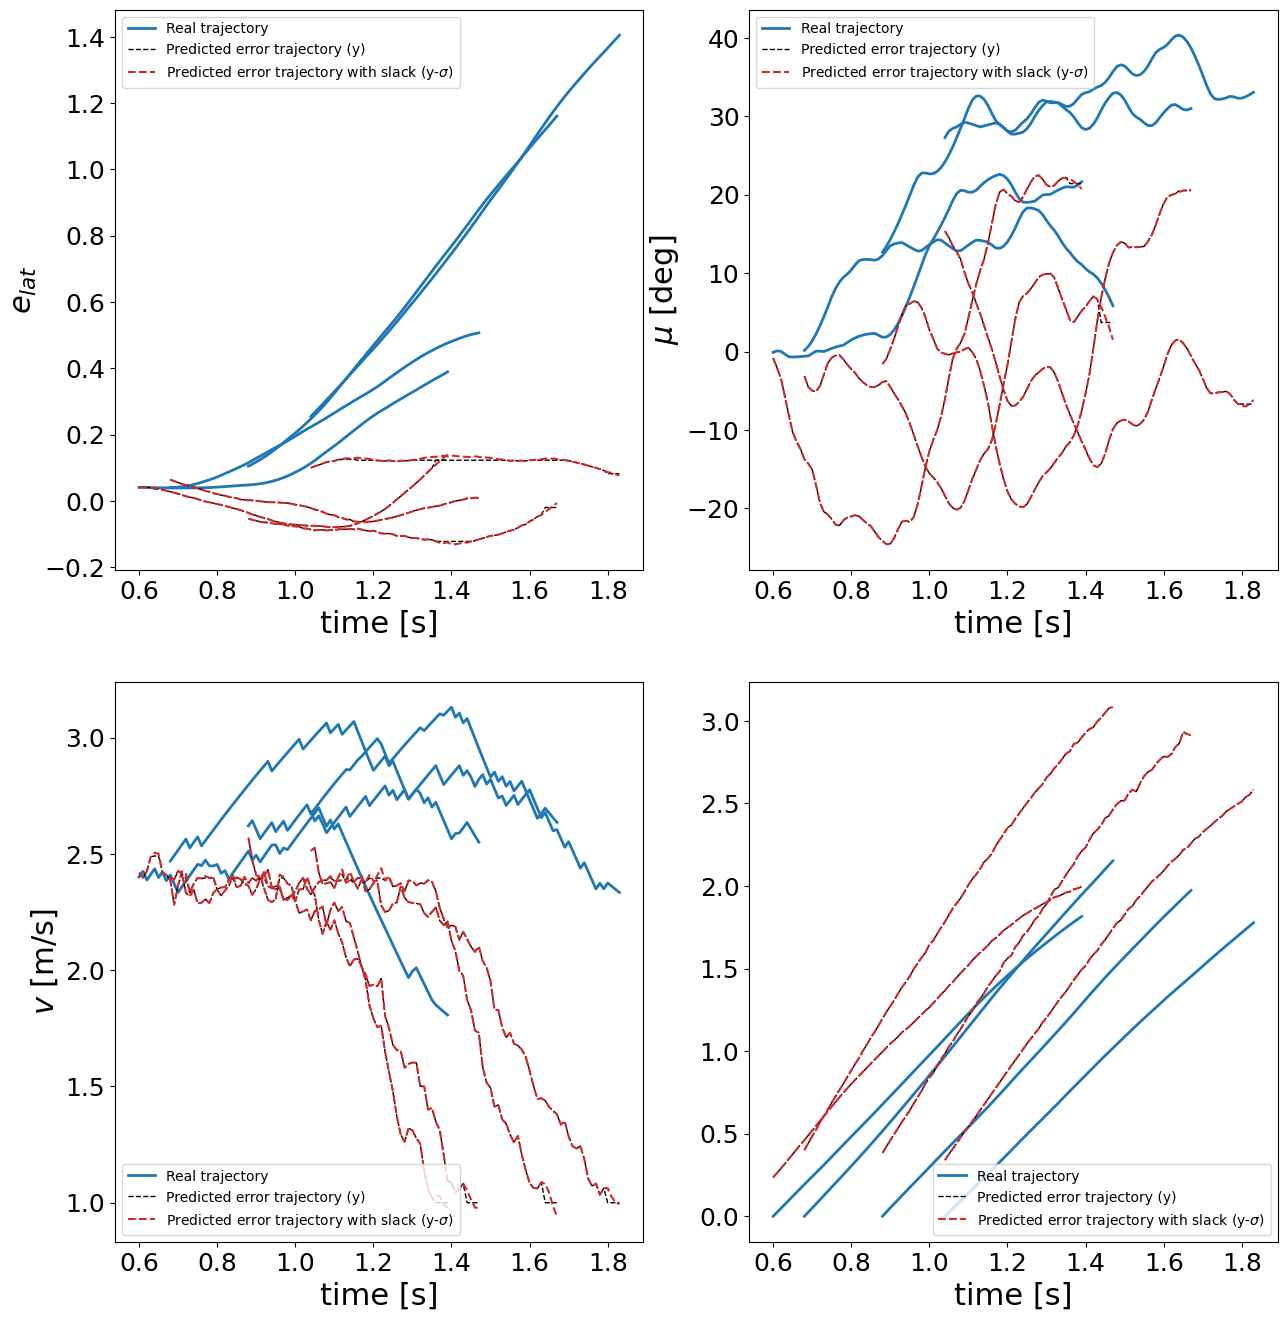

(5,)


In [8]:
# plot given predicted trajectory and real trajectory
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(15,16))
#velocity input
ax = plt.subplot(221)
time_spans = [(t-0.5, t) for t in results.violating_time_steps[0:1]]
# results.plot_error_trajectory(0, ax, constraint=(-simulator.track_width/2, simulator.track_width/2))
results.plot_error_slices(0, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(0, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(0, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
ax = plt.subplot(222)
# results.plot_error_trajectory(1, ax, constraint=(simulator.mu_min*180/np.pi, simulator.mu_max*180/np.pi))
results.plot_error_slices(1, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(1, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(1, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
ax = plt.subplot(223)
# results.plot_error_trajectory(2, ax)
results.plot_error_slices(2, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(2, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(2, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
ax = plt.subplot(224)
# results.plot_error_trajectory(2, ax)
results.plot_error_slices(4, ax, line_style=results.trajecory_style, time_span=time_spans)
results.plot_predicted_error_slices(4, ax, label_y_axis=True, time_span=time_spans)
results.plot_predicted_error_with_slack_slices(4, ax, line_style={'color': 'tab:red', 'linestyle': '--', 'linewidth': 1.5}, time_span=time_spans)
plt.show()
print(results._error_trajectory_slices[0][1][0].shape)

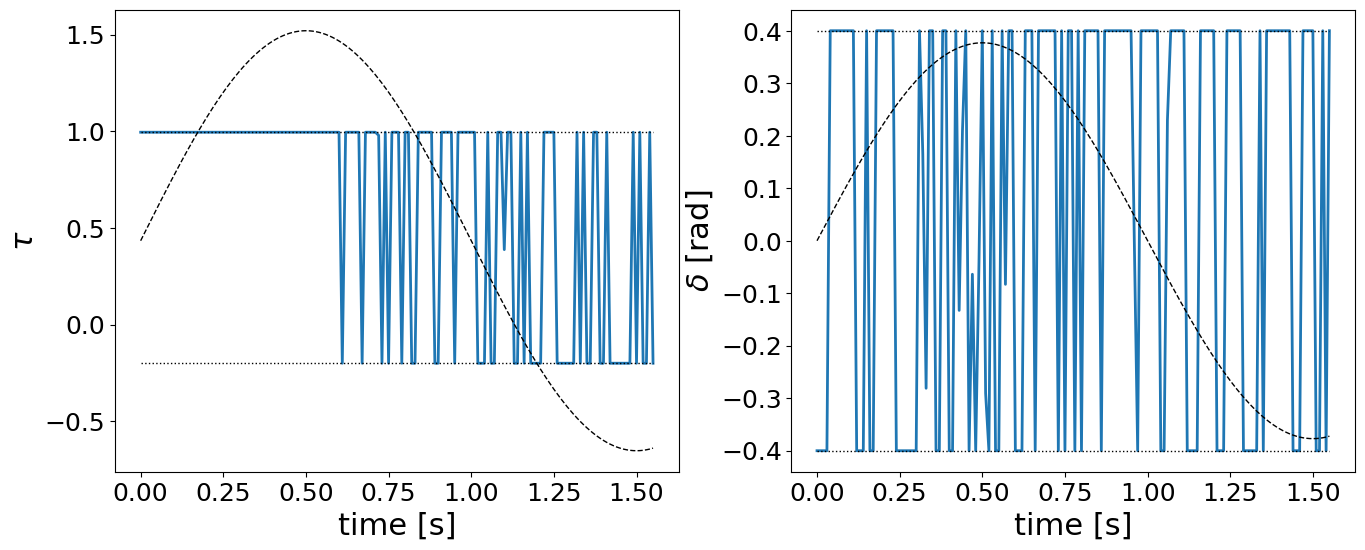

In [9]:
# plot given and applied inputs
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
results.plot_input_applied(0, ax, constraint=(simulator.a_min*simulator.m, simulator.a_max*simulator.m))
results.plot_input_obj(0, ax)
ax = plt.subplot(122)
results.plot_input_applied(1, ax, constraint=(-simulator.delta_max, simulator.delta_max))
results.plot_input_obj(1, ax)
# plt.show(block=True)
plt.savefig('fig/track_simulation_inputs.pdf', bbox_inches='tight')

In [10]:
sigma_max = results.calculate_sigma_infty_value()
print(sigma_max)

(0.01988428252984145, 0.40324339202726306)


In [11]:
sigma_max[1]/np.pi*180

23.104144479701482

In [12]:
def plot_average_itervention(ax: plt.Axes, results: Dict[TrackFilterTypes, Results]) -> plt.Axes:
    """Plot the average intervention for the input corresponds to the input."""
    width = 0.3 # width of bar

    x = np.arange(len(results))
    input_names = ['Torque', 'steering']

    offset = -width/2
    rects = ax.bar(x + offset, [round(result.average_intervention[0],2) for result in results.values()], width, label=input_names[0], color='tab:blue')
    ax.bar_label(rects, padding=3)
    ax.set_ylim(0, 1.5)
    ax.set_ylabel('Torque Intervention')
    ax.legend(loc='upper left', ncols=2)

    ax = ax.twinx()  # instantiate a second axes that shares the same x-axis
    offset = width/2
    rects = ax.bar(x + offset, [round(result.average_intervention[1],2) for result in results.values()], width, label=input_names[1], color='tab:red', hatch='///')
    ax.bar_label(rects, padding=3)
    ax.set_ylim(0, 0.5)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Steering Intervention')
    ax.set_title('MSR Input Intervention for Different Terminal Ingredients')
    ax.set_xticks(x, [key.value for key in results.keys()])
    ax.legend(loc='upper right', ncols=2)
    

In [13]:
results_dict_filter_types = {
    key[2]: result_list[0] for key, result_list in dict_results.items()
}
print(results_dict_filter_types)
fig, ax = plt.subplots(layout='constrained')

ax = plot_average_itervention(ax, results_dict_filter_types)

NameError: name 'dict_results' is not defined

In [ ]:
io_data = simulator.io_data_dict[1/0.5]

plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [y[0,0] for y in io_data._output_data])

KeyError: 2.0

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [y[1,0]*180/np.pi for y in io_data._output_data])

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [y[2,0] for y in io_data._output_data])

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [u[0,0] for u in io_data._input_data])

In [ ]:
plt.plot(np.linspace(0, simulator.Ts*io_data.length, io_data.length), [u[1,0] for u in io_data._input_data])

In [ ]:
error_list = []
for predicted_traj, real_traj in zip(results._predicted_error_with_slack_slices, results._error_trajectory_slices):
    predicted_traj = predicted_traj[1] # extract trajectory
    real_traj = real_traj[1] # extract trajectory
    for predicted_state, real_state in zip(predicted_traj[:], real_traj[:]):
        error_list.append(predicted_state - real_state)

In [ ]:
np.sqrt(np.sum([error[0]**2 for error in error_list])/len(error_list))

In [ ]:
i = 2
# print(simulator.systems[i].cur)
io_data_list = simulator.filter._safety_filters[i]._io_data_list
for io_data in io_data_list:
    print(len(io_data._input_data))

In [ ]:
import os
import pickle
# # curvature, sample time, [list of time length of io_datas]
# with open(os.path.join(os.getcwd(), 'datasets', f'io_data_random_2.0_0.01_160_240.pkl'), 'wb') as file:
#                         pickle.dump(io_data_list, file)

In [ ]:
results.mean_calculation_time

In [ ]:
print(len(simulator.buffer_u_value[0][1]))
print(simulator.buffer_u_value[0][1][0])
print(len(simulator.buffer_y_value[0][1]))
print(simulator.buffer_y_value[0][1][0])


In [ ]:
# from scipy.spatial import ConvexHull, Voronoi
# H_uy = results.H_uy
# H_uy = np.array(H_uy.T)

# vor = Voronoi(H_uy)
# cov_hull = ConvexHull(H_uy)